In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
configs = [
    ['qqp', 'default', 200, 5000],
    ['qqp', 'variance-4', 200, 5000],
    ['mrpc', 'default', 100, 500],
]

In [3]:
def moving_average(data, window_size):
    """Compute the moving average of a list or array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


In [4]:
def read_sensitivity_from_log(model_name, data_name, exp_name, window_size):
    log_path = f'./logs/{data_name}/{model_name}/{exp_name}/logfile.log'
    with open(log_path, 'r') as f:
        lines = f.readlines()
    keyword = "validation: sensitivity mean: "
    sensitivity_list = []
    for line in lines:
        if keyword in line:
            sensitivity = float(line.split(keyword)[-1].removesuffix('\n'))
            sensitivity_list.append(sensitivity)
    return np.array(sensitivity_list)

In [5]:
data_name, exp_name, window_size, report_number = configs[0]

In [6]:
metric = 'sensitivity'
sensitivity_data = {
    'lstm': moving_average(
        read_sensitivity_from_log('lstm', data_name, 'layernorm', window_size),
        window_size=window_size),
    'roberta': moving_average(
        read_sensitivity_from_log('roberta-scratch',  data_name, exp_name, window_size), 
        window_size=window_size),
    'roberta (relu)': moving_average(
        read_sensitivity_from_log('roberta-scratch_relu',  data_name, exp_name, window_size),
        window_size=window_size)
}

In [8]:
import matplotlib.ticker as mtick

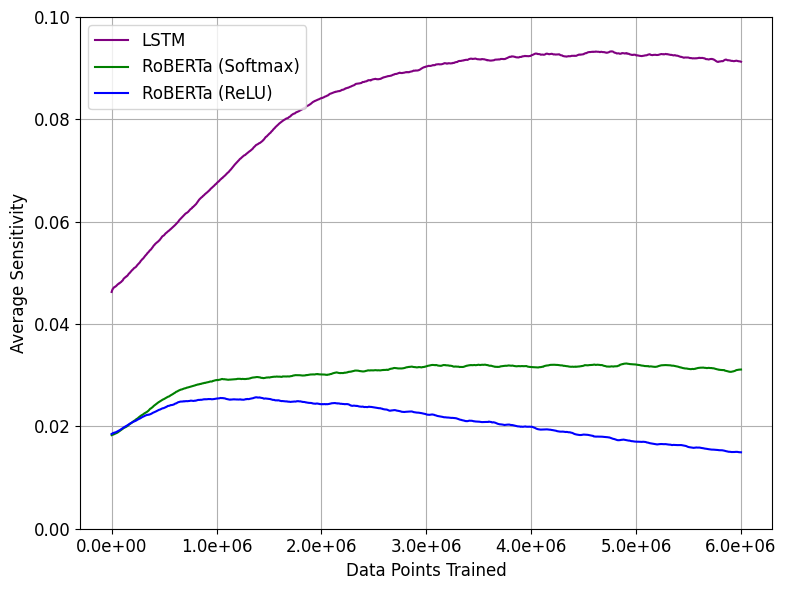

In [9]:
RANGE = 1201
xs = (np.arange(RANGE) * report_number).astype(np.int32).tolist()
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8, 6))
ax.plot(xs, sensitivity_data['lstm'][:RANGE], label='LSTM', color='purple')
ax.plot(xs, sensitivity_data['roberta'][:RANGE], label='RoBERTa (Softmax)', color='green')
ax.plot(xs, sensitivity_data['roberta (relu)'][:RANGE], label='RoBERTa (ReLU)', color='blue')
ax.set_xlabel(f'Data Points Trained', fontsize=12)
ax.set_ylabel(f'Average Sensitivity', fontsize=12)
#ax.ticklabel_format(useOffset=False)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
#ax.set_ylim([0.0, 0.05])
ax.set_ylim([0.0, 0.1])

#plt.title('Change of Average Sensitivity with Data Points Trained')
plt.legend(loc = 'upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
#plt.show()
plt.savefig(f'{data_name}_sensitivity.pdf', dpi=200, bbox_inches='tight', pad_inches=0.05)

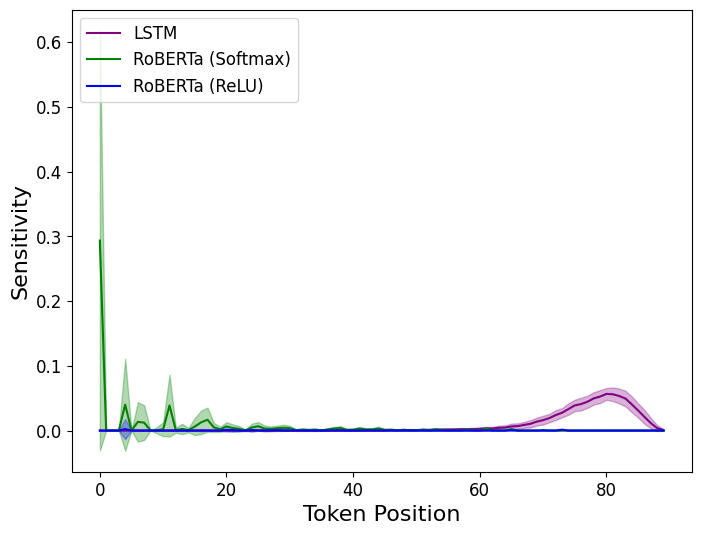

In [157]:
import numpy as np
import matplotlib.pyplot as plt

data_name = 'mrpc'
# Function to compute average and standard deviation for the last 100 rows
def compute_stats(data):
    if data.shape[0] >= 100:
        last_100_rows = data[-100:]
        average = np.mean(last_100_rows, axis=0)
        std_deviation = np.sqrt(np.var(last_100_rows, axis=0))  # Standard deviation
        return average, std_deviation
    else:
        return None, None
# Load the data
lstm_sens_pos = np.load(f"logs/{data_name}/lstm/layernorm/sensitivity.npy")
roberta_sens_pos = np.load(f"logs/{data_name}/roberta-scratch/default/sensitivity.npy")
roberta_relu_sens_pos = np.load(f"logs/{data_name}/roberta-scratch_relu/default/sensitivity.npy")
# Compute stats for each dataset
lstm_avg, lstm_std = compute_stats(lstm_sens_pos)
roberta_avg, roberta_std = compute_stats(roberta_sens_pos)
roberta_relu_avg, roberta_relu_std = compute_stats(roberta_relu_sens_pos)
# Plotting
plt.figure(figsize=(8, 6))
# Check if the data was sufficient and plot
if lstm_avg is not None and lstm_std is not None:
    length = len(lstm_avg)
    plt.plot(range(length), lstm_avg, label='LSTM', color='purple')
    plt.fill_between(range(len(lstm_avg)), lstm_avg - lstm_std, lstm_avg + lstm_std,
                     color='purple', alpha=0.3)
if roberta_avg is not None and roberta_std is not None:
    length = len(roberta_avg)
    plt.plot(range(length), roberta_avg, label='RoBERTa (Softmax)', color='green')
    plt.fill_between(range(len(roberta_avg)), roberta_avg - roberta_std, roberta_avg + roberta_std,
                     color='green', alpha=0.3)
if roberta_relu_avg is not None and roberta_relu_std is not None:
    length = len(roberta_relu_avg)
    plt.plot(range(length),roberta_relu_avg, label='RoBERTa (ReLU)', color='blue')
    plt.fill_between(range(len(roberta_relu_avg)), roberta_relu_avg - roberta_relu_std, roberta_relu_avg + roberta_relu_std,
                     color='blue', alpha=0.3)
plt.xlabel('Token Position', fontsize=16)
plt.ylabel('Sensitivity', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Average Sensitity over Token Position')
plt.legend(loc='upper left', fontsize=12)
plt.savefig(f'{data_name}_token_position.pdf', dpi=200, bbox_inches='tight', pad_inches=0.05)